# CIFAR-10 Work 1

2018/5/31

Exploration of the cifar10 dataset for [Fast.ai/NRL CV research](http://forums.fast.ai/t/research-collaboration-opportunity-with-leslie-smith/16454/). No specific goals for this notebook; only to get comfortable with the data and establish workflows for the next round of experiments.

W.Nixalo

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *

In [2]:
PATH = Path('data/cifar10')

In [96]:
def count_files(path, fullpath=Path(), count=0):
    """Counts all files in a directory recursively."""
    fullpath /= path
    # check root exists
    if not os.path.exists(fullpath):
        print('Directory does not exist.')
        return
    dirs = os.listdir(fullpath)
    for direc in dirs:
        if (fullpath/direc).is_dir():
            count += count_files(direc, fullpath)
        else:
            count += 1
    return count
            
# MacOS creates a .DS_Store file when files are copied and/or unzipped.
# This will cause problems if using `.from_paths` to load data.
def remove_dstore(path, fullpath=Path()):
    """Removes all '.DS_Store' files in directory recursively."""
    fullpath /= path
    PATH.is_dir
    dirs = os.listdir(fullpath)
    for direc in dirs:
        if direc.lower() == '.ds_store':
            os.remove(fullpath/direc)
            continue
        if (fullpath/direc).is_dir(): remove_dstore(direc, fullpath)

def reset_data(path, trn_name='train', val_name='valid'):
    """Moves all validation data back to their respective training folders."""
    remove_dstore(path/trn_name)
    remove_dstore(path/val_name)
    
    cats = os.listdir(path/val_name)
    for cat in cats:
        fnames = os.listdir(path/val_name/cat)
        for fname in fnames:
            os.rename(path/val_name/cat/fname, path/trn_name/cat/fname)
        # will remove entire val folder
        os.removedirs(path/val_name/cat)

def create_valset(path, p=0.15, trn_name='train', val_name='valid'):
    """Creates a validation set by moving a percentage of the training data 
       from `trn_name` to `val_name`."""
    if not os.path.exists(path / val_name):
        os.makedirs(path / val_name)
    else:
        reset_data(path, trn_name=trn_name, val_name=val_name)
    
    cats = os.listdir(path/trn_name)
    for cat in cats:
        os.makedirs(path/val_name/cat, exist_ok=True)
        moves = os.listdir(path/trn_name/cat)
        nmove = int(len(moves)*p)
        moves = np.random.choice(moves, nmove, replace=False)
        for move in moves:
            os.rename(path/trn_name/cat/move, path/val_name/cat/move)

Would actually be much easier to just build a csv of all the files next time.

In [100]:
create_valset(PATH)
count_files(PATH/'train'), count_files(PATH/'valid')

(42500, 7500)

In [101]:
sz = 32
bs = 64

## Simple Learner

So I think you use `test_with_labels` in `.from_paths` when the test data has implicit label structure (ie: it's separated into folders by class). This uses `dataset.folder_source`. Otherwise `dataest.read_dirs` is used, which I think looks at the top-level directory assuming no class structure, and'll throw an error because your class folders are being treated like data.

In [103]:
tfms = tfms_from_model(resnet18, sz)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms,
    trn_name='train', val_name='valid', test_name='test', num_workers=2, 
    test_with_labels=True)

In [104]:
learner = ConvLearner.pretrained(resnet18, model_data)

 84%|████████▎ | 556/665 [03:55<00:46,  2.36it/s, loss=6.36]

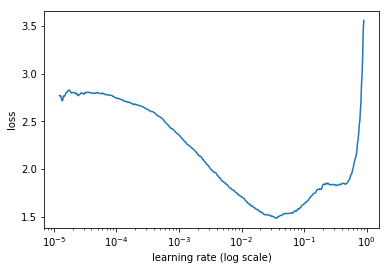

In [105]:
learner.lr_find()
learner.sched.plot()